# Optimize dual frame

This document shows you how to optimize the post-processing of the POVM samples to improve expectation value estimations.

In [1]:
%load_ext autoreload
%autoreload 2

## Getting the POVM samples

### Define quantum circuit

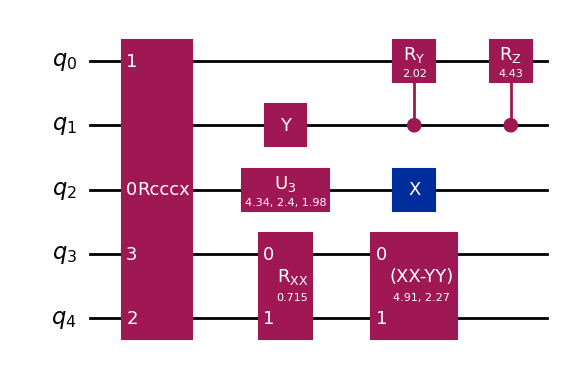

In [2]:
from qiskit.circuit.random import random_circuit

qc = random_circuit(5, 3, measure=False, seed=875)
qc.draw("mpl", style="iqp")

### Define measurement procedure

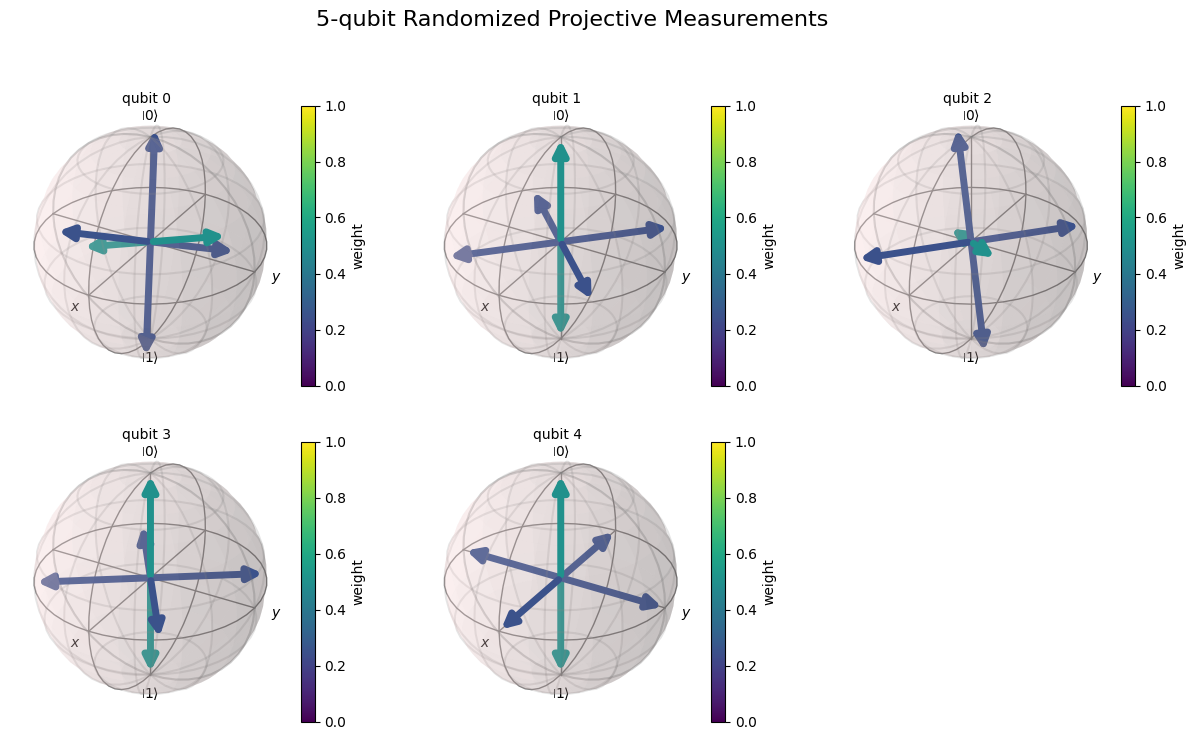

In [3]:
import numpy as np
from numpy.random import default_rng
from povm_toolbox.library import RandomizedProjectiveMeasurements

rng = default_rng(96568)

num_qubits = qc.num_qubits

bias = np.array([0.5, 0.25, 0.25])
angles = np.array(
    [
        [2.01757238, -1.85001671, 2.52155716, 0.45636669, 1.17175533, -0.48263278],
        [0.0, 0.0, 1.57079633, -2.35619449, 1.57079633, -0.78539816],
        [1.94493547, -2.39620342, 0.3760775, -2.28966468, 1.53443501, 2.33046898],
        [0.0, 0.0, 1.57079633, 0.6, 1.57079633, 2.17079633],
        [0.0, 0.0, 1.57079633, 0.0, 1.57079633, 1.57079633],
    ]
)

measurement = RandomizedProjectiveMeasurements(num_qubits, bias=bias, angles=angles, seed=rng)
measurement.definition().draw_bloch(
    title=f"{num_qubits}-qubit Randomized Projective Measurements", colorbar=True
)

### Run the job

Initialize `Sampler` and `POVMSampler`. Then run the job.

In [4]:
from povm_toolbox.sampler import POVMSampler
from qiskit.primitives import StatevectorSampler

sampler = StatevectorSampler(seed=rng)
povm_sampler = POVMSampler(sampler=sampler)

job = povm_sampler.run([qc], shots=4096, povm=measurement)
pub_result = job.result()[0]

### Define observable

In [5]:
from qiskit.quantum_info import SparsePauliOp

observable = SparsePauliOp(
    ["XIIII", "IIYII", num_qubits * "Y", num_qubits * "Z"], coeffs=[1.3, 1.2, -1, 1.4]
)

## Choosing the dual frame

Given a POVM $\{M_k\}_k$, a dual frame $\{D_k\}_k$ can be obtained through 
$$D_k = \frac{1}{\alpha_k}\mathcal{F}_{\alpha}^{-1}(M_k)$$
where the parametrized frame super-operator $\mathcal{F}_{\alpha}$ is defined as
$$\mathcal{F}_{\alpha} : X \mapsto \sum_k \frac{\mathrm{Tr}[X M_k]}{\alpha_k} M_k$$
for parameters $\{\alpha_k\}_k \subset \mathbb{R}$.

Note that scaling all the parameters by a fixed coefficient results in the same dual frame.

### State-average dual frame (or *canonical estimators*)

The default case implemented in the `POVMPostProcessor` is to use the state-average dual frame, which is defined by parameters 
$$\alpha_k = \mathrm{Tr}[M_k] \, .$$
It is optimal with respect to the fully-mixed state $\mathbb{I}_d / d$ (which is the average state under the Haar measure). Therefore, this is the optimal dual frame when we have no knowledge about the state.
As soon as we have some knowledge about the state (for instance through measurement outcomes), we can generally improve the performance of this dual frame.

The operators of the state-average dual frame are sometimes referred to as the *canonical estimators*.

In [6]:
from povm_toolbox.post_processor import POVMPostProcessor
from qiskit.quantum_info import Statevector

exact_expectation_value = np.real_if_close(Statevector(qc).expectation_value(observable))
print(f"Exact value:     {exact_expectation_value}")

post_processor = POVMPostProcessor(pub_result)

exp_value_canonical, std_canonical = post_processor.get_expectation_value(observable)
print(f"Estimated value: {exp_value_canonical}")
print(f"\nEstimated standard deviation of the estimator: {std_canonical}")

Exact value:     0.9786732290044555
Estimated value: 0.7885807349016069

Estimated standard deviation of the estimator: 0.40445067321743994


### State-marginal dual frame

Here we use the state-marginal dual frame, which requires the knowledge of the sampled state $\rho$. More specifically, we compute the outcome probabilities 
$$p_{k1,...,k_N} = \mathrm{Tr}[M_{k1,...,k_N} \rho] $$ 
where the POVM is assumed to have a product structure. We then marginalize these outcome probabilities to ensure that the dual frame will also have a product structure. That is, we set the parameters of the dual frame to
$$\alpha_{k1,...,k_N} = p^{(1)}_{k_1} \cdots p^{(N)}_{k_N}$$
where $p^{(i)}_{k_i}$ is the (marginal) probability of obtaining outcome $k_i$ on qubit $i$.

The caveat of this dual frame is that we do not have access to the state $\rho$ in general. However, it does work for testing and/or teaching purposes.

In [7]:
from povm_toolbox.post_processor import dual_from_marginal_probabilities

post_processor.dual = dual_from_marginal_probabilities(
    povm=post_processor.povm, state=Statevector(qc)
)

exp_value_marginal, std_marginal = post_processor.get_expectation_value(observable)
print(f"Estimated value: {exp_value_marginal}")
print(f"\nEstimated standard deviation of the estimator: {std_marginal}")

Estimated value: 0.997097414528348

Estimated standard deviation of the estimator: 0.3041460424519631


### Empirical frequencies dual frame

We now present a dual frame that uses the same idea as for the state-marginal dual frame, but without requiring the knowledge of the state $\rho$ a priori.
More precisely, we replace the marginal outcome probabilities by the empirical outcome frequencies:
$$\alpha_{k1,...,k_N} = f^{(1)}_{k_1} \cdots f^{(N)}_{k_N}$$
where $f^{(i)}_{k_i} = \# k_i / S$ is the number of time we sampled outcome $k_i$ on qubit $i$ divided by the total number of shots $S$.

To add stability of the estimator (and avoid parameters set to 0 if an outcome was not sampled), we add a bias term to the frequencies as 
$$f^{(i)}_{k_i} = \frac{\# k_i + \mathrm{Tr}[\rho_{\mathrm{bias}} M^{(i)}_{k_i}] S_{\mathrm{bias}}}{S + S_{\mathrm{bias}}} \, ,$$
where $\rho_{\mathrm{bias}}$ is an ansatz state (by default set to $\frac{1}{d}\mathbb{I}$) and $S_{\mathrm{bias}}$ is the strength of the bias (by default set to the number of outcomes of the local POVM).

We have two edge cases:
* In the limit $S \to 0$, we recover the state-average dual frame if $\rho_{\mathrm{bias}}=\frac{1}{d}\mathbb{I}$.
* In the limit $S \to \infty$, we recover the marginal-state dual frame (independently of $\rho_{\mathrm{bias}}$).

In [8]:
from povm_toolbox.post_processor import dual_from_empirical_frequencies

post_processor.dual = dual_from_empirical_frequencies(povm_post_processor=post_processor)

exp_value_freq, std_freq = post_processor.get_expectation_value(observable)
print(f"Estimated value: {exp_value_freq}")
print(f"\nEstimated standard deviation of the estimator: {std_freq}")

Estimated value: 1.0142327046855542

Estimated standard deviation of the estimator: 0.30334996039158424


## Summary 

We finally compare the estimates obtained with the different dual frames.

In [9]:
print(f"Exact value: {exact_expectation_value}\n")

print("Dual frame              Estimated value   Estimated std   Actual error")
print("------------------------------------------------------------------------")
print(
    f"canonical estimators {exp_value_canonical:>18.6f} {std_canonical:>15.6f} {abs(exp_value_canonical - exact_expectation_value):>14.6f}"
)
print(
    f"marginal probabilities {exp_value_marginal:>16.6f} {std_marginal:>15.6f} {abs(exp_value_marginal - exact_expectation_value):>14.6f}"
)
print(
    f"empirical frequencies {exp_value_freq:>17.6f} {std_freq:>15.6f} {abs(exp_value_freq - exact_expectation_value):>14.6f}"
)

Exact value: 0.9786732290044555

Dual frame              Estimated value   Estimated std   Actual error
------------------------------------------------------------------------
canonical estimators           0.788581        0.404451       0.190092
marginal probabilities         0.997097        0.304146       0.018424
empirical frequencies          1.014233        0.303350       0.035559
